# Edward and Mack Final Assignment Machine Learning 445 

In [20]:
%pip install bayesian-optimization torch torchvision pandas seaborn matplotlib scikit-learn datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from bayes_opt import BayesianOptimization as bo
import pandas as pd
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import psutil
import os


device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print("Using device:", device)

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


Using device: mps


In [35]:
import torch
from datasets import load_dataset
from transformers import default_data_collator
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import (
    Compose, Resize, RandomHorizontalFlip,
    ToImage, ToDtype, Normalize
)

BATCH_SIZE  = 128
IMAGE_SIZE  = (64, 64)

ds          = load_dataset("zh-plus/tiny-imagenet")
train_val   = ds["train"].train_test_split(test_size=0.1, seed=42,
                                           stratify_by_column="label")
train_ds    = train_val["train"]
val_ds      = train_val["test"]
test_ds     = ds["valid"]

train_ds = train_ds.with_format("torch")
val_ds   = val_ds.with_format("torch")
test_ds  = test_ds.with_format("torch")

tfms = Compose([
    ToImage(),                                   # converts PIL → uint8 CHW tensor
    Resize(IMAGE_SIZE),
    RandomHorizontalFlip(),
    ToDtype(torch.float32, scale=True),          # 0-1 float
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225]),
])

def add_tfms(example):
    example["image"] = tfms(example["image"])
    return example

train_ds = train_ds.with_transform(add_tfms)
val_ds   = val_ds.with_transform(add_tfms)
test_ds  = test_ds.with_transform(add_tfms)

loader_cfg = dict(batch_size=BATCH_SIZE,
                  num_workers=0,
                  pin_memory=True,
                  collate_fn=default_data_collator)

train_loader = DataLoader(train_ds, shuffle=True,  **loader_cfg)
val_loader   = DataLoader(val_ds,   shuffle=False, **loader_cfg)
test_loader  = DataLoader(test_ds,  shuffle=False, **loader_cfg)

if __name__ == "__main__":
    batch = next(iter(train_loader))
    print("Image batch:", batch["image"].shape, batch["image"].dtype)   # (128, 3, 64, 64)
    print("Label batch:", batch["labels"].shape, batch["labels"].dtype) # (128,) torch.int64


Image batch: torch.Size([128, 3, 64, 64]) torch.float32
Label batch: torch.Size([128]) torch.int64


In [42]:
print(batch["image"].reshape(-1))

tensor([2.2489, 2.2489, 2.2489,  ..., 2.3088, 2.3088, 2.3088])


In [43]:
imgs = batch["image"]

print(imgs.min().item(), imgs.max().item())  
print(imgs.mean().item(), imgs.std().item())

B, C, H, W = imgs.shape
assert imgs.numel() == 128*3*64*64
assert batch["labels"].shape == (B,)
assert imgs.dtype  == torch.float32
assert batch["labels"].dtype == torch.int64


-2.1179039478302 2.640000104904175
-0.030960217118263245 1.242540955543518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


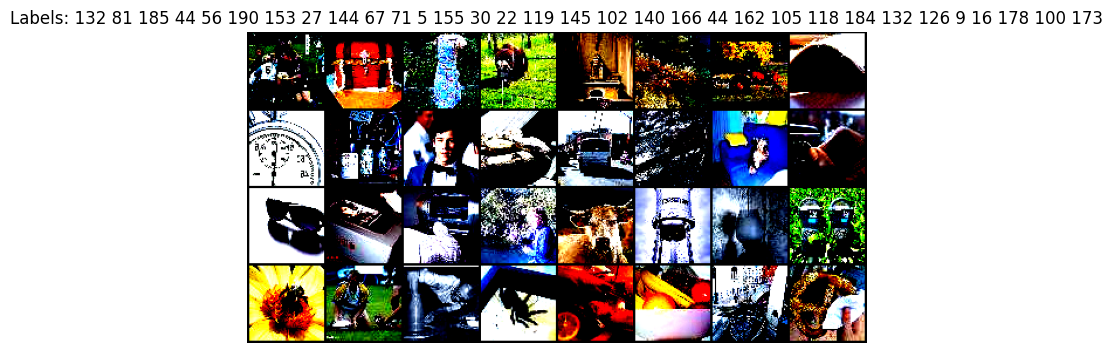

In [60]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

batch   = next(iter(train_loader))
images  = batch["image"]                          # shape (B, 3, H, W)
labels  = batch["labels"] if "labels" in batch else batch["label"]

grid = make_grid(images[:32], nrow=8, padding=2)  # (3, H’, W’)

npimg = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(npimg)
plt.axis("off")
plt.title("Labels: " + " ".join(str(x) for x in labels[:32].tolist()))
plt.show()


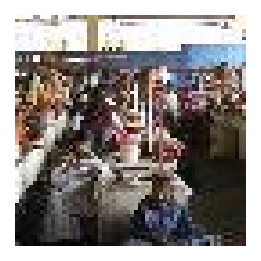

In [61]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

img = imgs[0] * std + mean          # (3, 64, 64)
img = img.clamp(0, 1)               

plt.figure(figsize=(2, 2), dpi=150)
plt.imshow(img.permute(1, 2, 0).cpu(), interpolation='nearest')
plt.axis('off')
plt.show()



# 2-D CNN MLP

In [74]:
from typing import Sequence, Union, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(
        self,
        input_shape: Tuple[int, int, int],
        conv_channels: Sequence[int],
        conv_kernels: Union[int, Sequence[int]] = 3,
        fc_hidden:    Union[int, Sequence[int]] = 512,
        n_outputs:    int = 200,
        activation:   str = "relu",
    ):
        super().__init__()

        # normalise arguments 
        if isinstance(conv_kernels, int):
            conv_kernels = [conv_kernels] * len(conv_channels)
        if isinstance(fc_hidden, int):
            fc_hidden = [] if fc_hidden == 0 else [fc_hidden]

        if len(conv_kernels) != len(conv_channels):
            raise ValueError("conv_channels and conv_kernels must match length")

        acts = {"relu": nn.ReLU(), "tanh": nn.Tanh(),
                "gelu": nn.GELU(), "identity": nn.Identity()}
        if activation not in acts:
            raise ValueError(f"Unsupported activation '{activation}'")
        act = acts[activation]

        # conv + pool stack
        C_in, H, W = input_shape
        k1, k2 = conv_kernels
        c1, c2 = conv_channels

        self.conv1 = nn.Conv2d(C_in, c1, k1, padding=k1 // 2, bias=False)
        self.bn1   = nn.BatchNorm2d(c1)

        self.conv2 = nn.Conv2d(c1,  c2, k2, padding=k2 // 2, bias=False)
        self.bn2   = nn.BatchNorm2d(c2)

        self.pool  = nn.MaxPool2d(2)

        self.act = act

        # probe output shape automatically
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            dummy = self.pool(self.act(self.bn1(self.conv1(dummy))))
            dummy = self.pool(self.act(self.bn2(self.conv2(dummy))))
            flat_features = dummy.numel()   # total elements per sample

        # MLP head
        mlp_layers = []
        in_f = flat_features
        for out_f in fc_hidden:
            mlp_layers += [nn.Linear(in_f, out_f), act]
            in_f = out_f
        mlp_layers.append(nn.Linear(in_f, n_outputs))
        self.classifier = nn.Sequential(*mlp_layers)


    def forward_all_outputs(self, x: torch.Tensor) -> list[torch.Tensor]:
        Ys = [x]  # store original input

        # conv block 1 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        Ys.append(x)                 # after activation
        x = self.pool(x)
        Ys.append(x)                 # after pool

        # conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        Ys.append(x)
        x = self.pool(x)
        Ys.append(x)

        # flatten + classifier
        x = torch.flatten(x, 1)
        Ys.append(x)                 # flattened features

        for layer in self.classifier[:-1]:   # all hidden FC layers + activs
            x = layer(x)
            Ys.append(x)

        x = self.classifier[-1](x)   # final FC → logits
        Ys.append(x)

        return Ys

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward_all_outputs(x)[-1]



In [76]:
model = CNN(
    input_shape   =(3, 64, 64),
    conv_channels =[64, 128],
    conv_kernels  =[5, 3],
    fc_hidden     =512,
    n_outputs     =200,
)

x = torch.randn(4, 3, 64, 64)
print(model(x).shape)   # → torch.Size([4, 200])


torch.Size([4, 200])
